# ltu-ili lampe backend
This is a tutorial for using the lampe backend, showing how we can (1) use custom dataloaders and embedding networks and (2) do hyperparameter searches.

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch_geometric as pyg
import pandas as pd
import seaborn as sns
import tarp

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorSamples, PosteriorCoverage)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## QM7b Graph Dataset
This tutorial uses the MoleculeNet QM7b benchmarking dataset (https://arxiv.org/abs/1703.00564). The data is the molecular structure of various compounds, and the task is to infer various chemical properties.

In [15]:
# Using the QM7b dataset from pytorch geometric
# Ref: https://arxiv.org/abs/1703.00564

data = pyg.datasets.QM7b(root='./toy')  # download the dataset
x = data  # graph inputs
theta = data.y  # parameters

# Let's only look at the first 5 parameters
dim_theta = 5
theta = theta[:,:dim_theta]

tensor([-1.6250e+03,  6.1697e+00,  3.9735e-01, -8.8860e+00,  1.4410e+00])


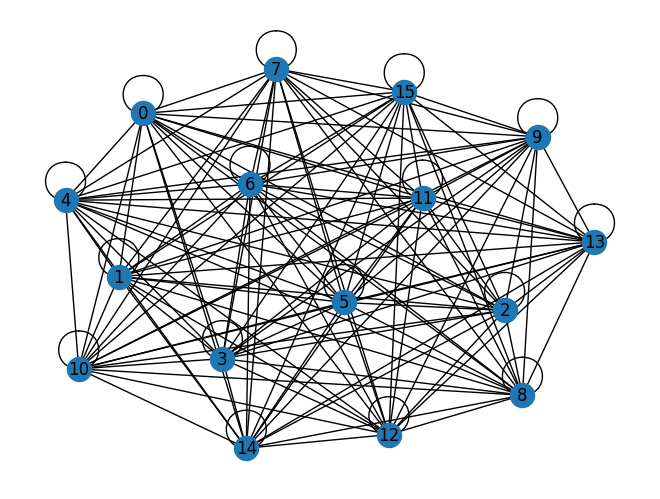

In [16]:
import networkx as nx

# plot an example molecule
i = np.random.randint(len(data))
x_, y_ = x[i], theta[i]
g = pyg.utils.to_networkx(x_, to_undirected=True)
nx.draw(g, with_labels=True)
print(y_)

In [17]:
# Create custom dataloaders using the torch_geometric collater

from torch.utils.data import DataLoader
from ili.dataloaders import TorchLoader
from torch_geometric.loader.dataloader import Collater

# use pyg's collater
collater = Collater(data)

# output (input, output) pairs
def collate_fn(batch):
    batch = collater(batch)
    return batch, batch.y[:,:dim_theta]

# train/val split
mask = np.random.rand(len(data)) < 0.9
train_data = data[mask]
val_data = data[~mask]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

# define an ili loader
loader = TorchLoader(train_loader, val_loader)
    

In [18]:
# Design a custom Graph Attention Network embedder

import torch
from torch_geometric import nn as gnn
from torch_geometric.nn import aggr
from torch import nn
import torch.nn.functional as F

class GATNetwork(nn.Module):
    def __init__(
        self, in_channels, gcn_channels, gcn_heads,
        dense_channels, out_channels, drop_p=0.1,
        edge_dim=None
    ):
        super().__init__()
        self.in_channels = in_channels
        self.dense_channels = dense_channels
        self.out_channels = out_channels
        self.drop_p = drop_p
        self.edge_dim = edge_dim
        self.gcn_channels = gcn_channels
        self.gcn_heads = gcn_heads

        self.graph_aggr = aggr.MultiAggregation(
            aggrs=['sum', 'mean', 'std', 'min',
                   'max', aggr.SoftmaxAggregation(learn=True)],
            mode='cat'
        )
        self.dropout = torch.nn.Dropout(p=self.drop_p)

        self._build_gnn()
        self._build_dnn(gcn_channels[-1]*len(self.graph_aggr.aggrs))
        
    def _build_dnn(self, in_channels):
        self.fc1 = torch.nn.Linear(in_channels, self.dense_channels[0])
        self.fcs = torch.nn.ModuleList(
            [torch.nn.Linear(self.dense_channels[i], self.dense_channels[i+1])
             for i in range(0, len(self.dense_channels)-1)])
        self.fc2 = torch.nn.Linear(self.dense_channels[-1], self.out_channels)

    def dnn(self, x):
        x = F.relu(self.fc1(x))
        for fc in self.fcs:
            x = self.dropout(x)
            x = F.relu(fc(x))
        x = self.fc2(x)
        return x
    
    def _build_gnn(self):
        self.conv1 = gnn.GATv2Conv(
            self.in_channels, self.gcn_channels[0], 
            heads=self.gcn_heads[0], edge_dim=self.edge_dim)
        self.convs = torch.nn.ModuleList(
            [gnn.GATv2Conv(self.gcn_channels[i]*self.gcn_heads[i],
                           self.gcn_channels[i+1], heads=self.gcn_heads[i+1],
                           edge_dim=self.edge_dim)
             for i in range(len(self.gcn_channels)-2)]
        )
        self.conv2 = gnn.GATv2Conv(
            self.gcn_channels[-2]*self.gcn_heads[-2],
            self.gcn_channels[-1], heads=self.gcn_heads[-1], 
            concat=False, edge_dim=self.edge_dim)

    def gnn(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        return x

    def forward(self, x):
        node_features = torch.ones(x.num_nodes, 1).to(x.y.device)
        edge_index, edge_attr = x.edge_index, x.edge_attr
        ptr = x.ptr if hasattr(x, 'ptr') else None

        x = self.gnn(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        x = self.graph_aggr(x, ptr=ptr)
        x = self.dnn(x)
        return x
    
embedding = GATNetwork(
    in_channels=1, gcn_channels=[4, 8], 
    gcn_heads=[4, 4],
    dense_channels=[32, 16], out_channels=6,
    edge_dim=1
)

In [19]:
# define a prior
prior = ili.utils.IndependentNormal(loc=[0]*dim_theta, scale=[1]*dim_theta, 
                                    device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, 
                             embedding_net=embedding, x_normalize=False, device=device),
    ili.utils.load_nde_lampe(model='mdn', hidden_features=50, num_components=6, 
                             embedding_net=embedding, x_normalize=False, device=device)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 2e-5,
    'stop_after_epochs': 30
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [20]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
235 epochs [12:32,  3.20s/ epochs, loss=8.74, loss_val=9.19]
INFO:root:Training model 2 / 2.
349 epochs [16:42,  2.87s/ epochs, loss=8.21, loss_val=8.47]
INFO:root:It took 1755.7009689807892 seconds to train models.


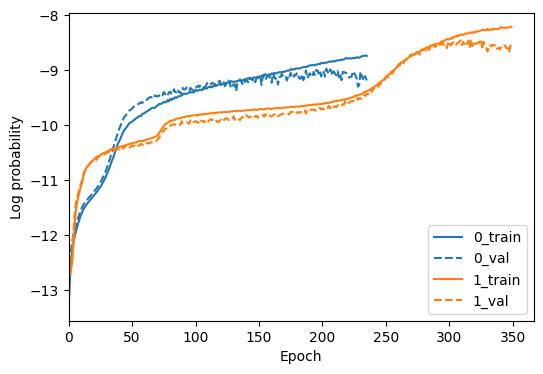

In [21]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [22]:
# Now, LampeRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = None
np.random.seed(seed_in)
ind = np.random.randint(len(data))
x_ = data[ind]
y_ = data.y[ind, :dim_theta]

# generate samples from the posterior using accept/reject sampling
seed_samp = 1234
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), data[ind])

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, data[ind])

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

INFO:root:Sampling models with tensor([369., 631.]) samples each.


['', '']


Drawing 631 posterior samples: 100%|██████████| 631/631 [00:00<00:00, 121370.53it/s]


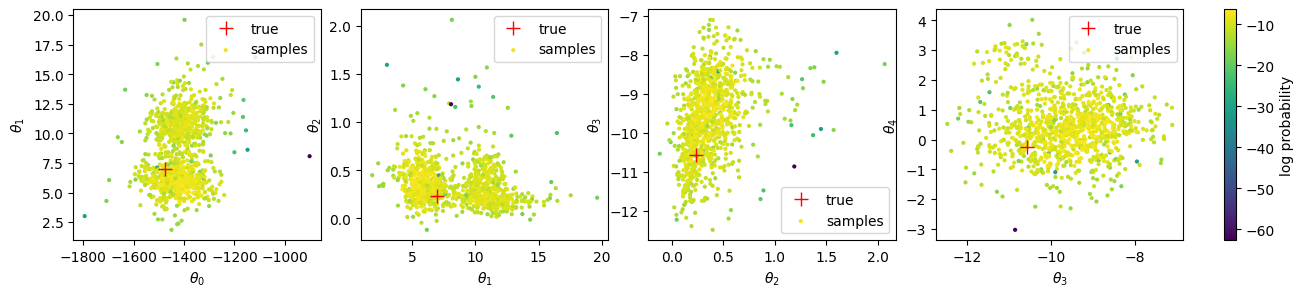

In [23]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, dim_theta, figsize=(3*dim_theta,3), 
                        gridspec_kw={'width_ratios': [1]*(dim_theta-1)+[0.05]})
for i in range(dim_theta-1):
    axs[i].plot(y_[i], y_[i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, 
                        label='samples')
    # axs[i].set_aspect('equal')
    # axs[i].set_xlim(-3,3)
    # axs[i].set_ylim(-3,3)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[-1])

INFO:root:Sampling models with tensor([369., 631.]) samples each.
Drawing 631 posterior samples: 100%|██████████| 631/631 [00:00<00:00, 182373.61it/s]


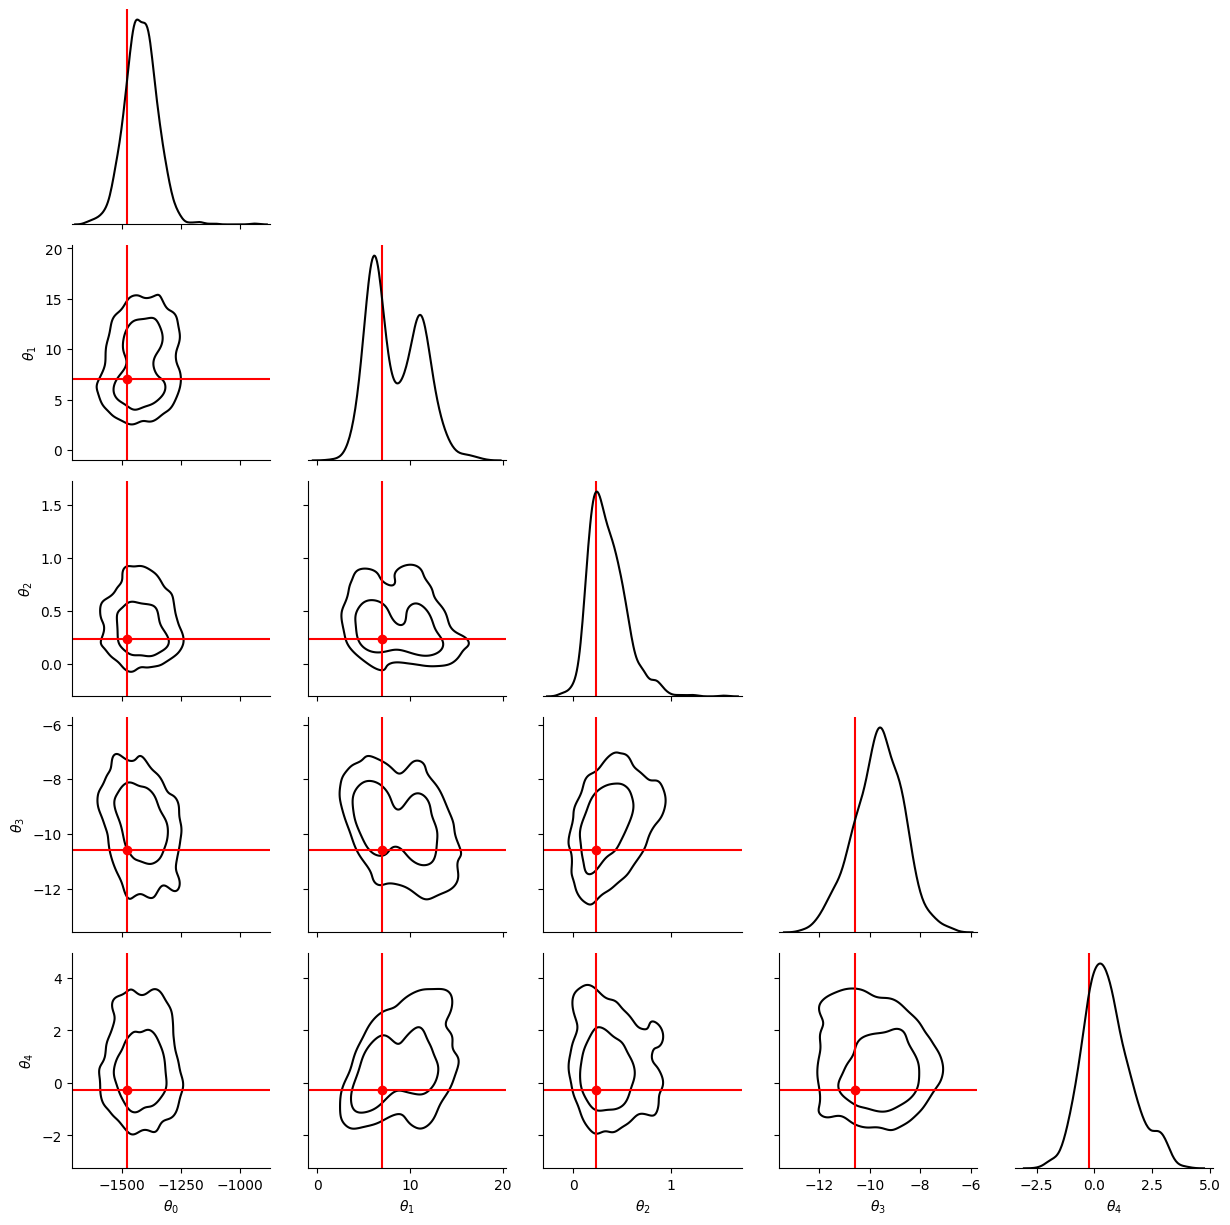

In [24]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_, theta_fid=y_
)

In [32]:
# Load data, custom for QM7b dataset
x = loader.train_loader.dataset
y = loader.train_loader.dataset.y

100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


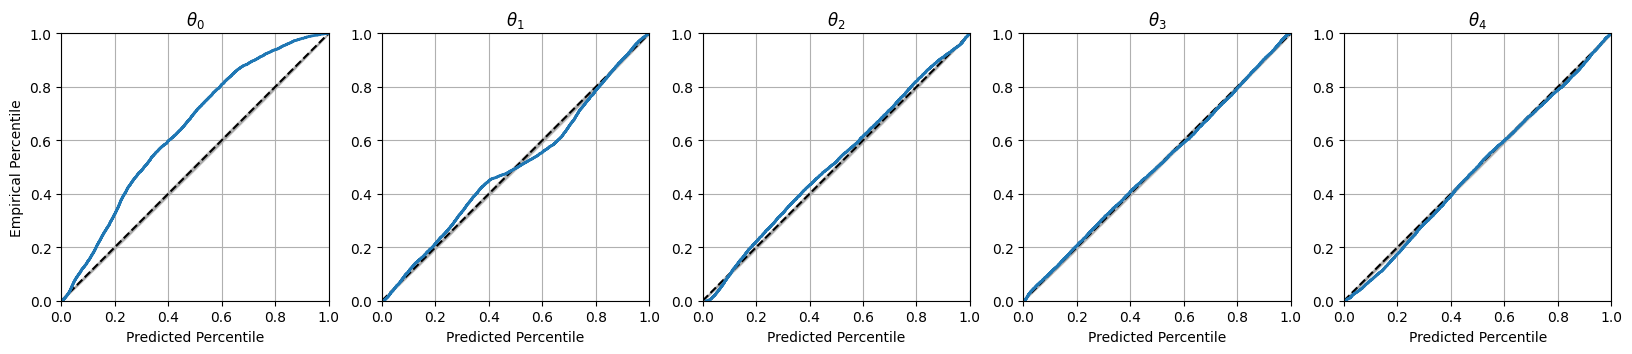

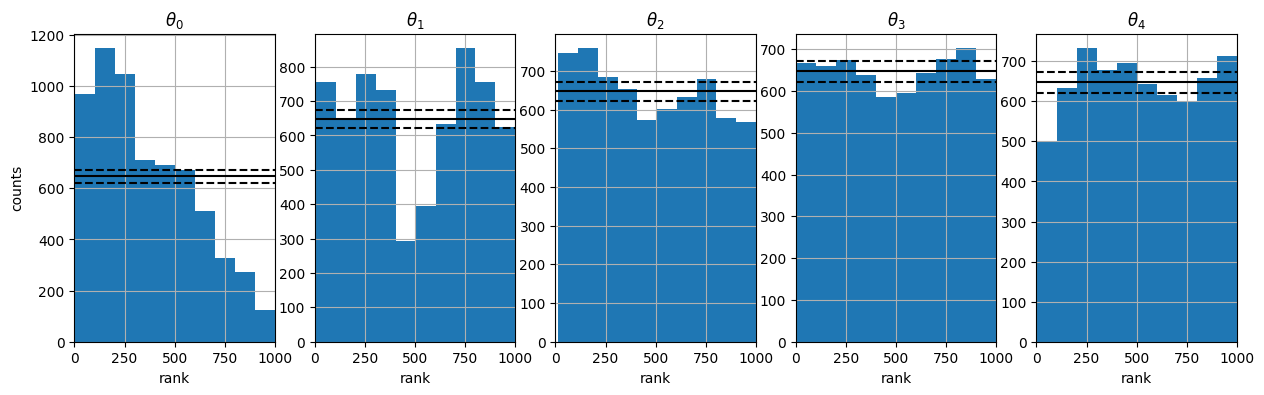

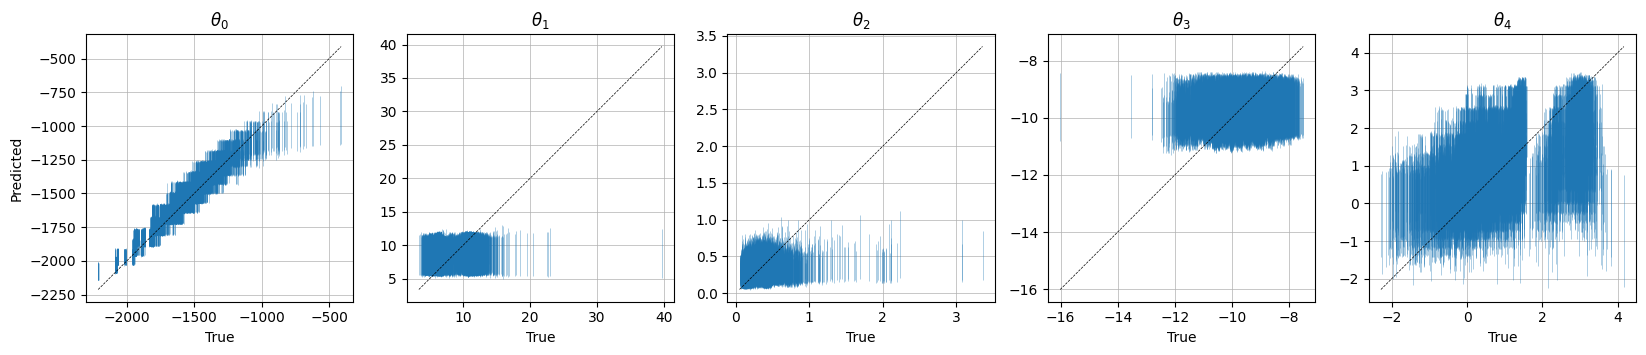

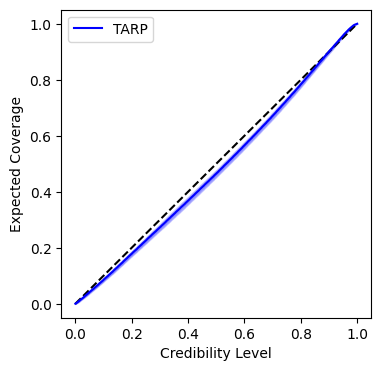

In [33]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble,
    x=x, theta=y[:, :dim_theta]
)

## Toy NPE Hyperparameter Search
This tutorial uses the synthetic toy example from [sbi.ipynb](./sbi.ipynb) to demonstrate how to do hyperparameter searches over model designs. This hyperparameter search is not unique to the lampe backend, but in fact can be used with any `ltu-ili` model.

In [2]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(5000, 3)  # 5000 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# train/val splits
val_split = 0.2
rand = np.random.rand(len(x))
val_mask = (rand < val_split)

# dataloaders
train_loader = NumpyLoader(x=x[~val_mask], theta=theta[~val_mask])
val_loader = NumpyLoader(x=x[val_mask], theta=theta[val_mask])

Here, we test the use of the nine NDE architectures available in lampe. They are described in the documentation of [`ili.utils.load_nde_lampe`](https://github.com/maho3/ltu-ili/blob/430482eaaba654fcd27ca736a89f24d8ae5a973d/ili/utils/ndes_pt.py#L243). One could equivalently compare different architecture widths, depths, training arguments, etc.

In [3]:
# hyperparameters
models = ['mdn', 'maf', 'nsf', 'nice', 'gf', 'sospf', 'naf', 'unaf']

# setup static hyperparameters
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)
train_args = {
    'training_batch_size': 32,
    'learning_rate': 2e-4
}

# setup trainer
def setup_trainer(modeltype):
    nets = [
        ili.utils.load_nde_lampe(model=modeltype, hidden_features=8)
    ]
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args,
    )
    return runner

runners = {model: setup_trainer(model) for model in models}

In [4]:
# train
posteriors, summaries = {}, {}
for m, runner in runners.items():
    print('\nTraining', m)
    p, s = runner(loader=train_loader)
    posteriors[m] = p
    summaries[m] = s

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training mdn


367 epochs [01:09,  5.30 epochs/s, loss=-3.09, loss_val=-3.08]
INFO:root:It took 69.20280694961548 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training maf


520 epochs [01:28,  5.88 epochs/s, loss=-4.76, loss_val=-4.59]
INFO:root:It took 88.40885090827942 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training nsf


368 epochs [02:16,  2.69 epochs/s, loss=-4.88, loss_val=-4.82]
INFO:root:It took 136.82938599586487 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training nice


744 epochs [02:08,  5.80 epochs/s, loss=-4.71, loss_val=-4.62]
INFO:root:It took 128.17003989219666 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training gf


455 epochs [02:09,  3.52 epochs/s, loss=-4.87, loss_val=-4.79]
INFO:root:It took 129.44944095611572 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training sospf


647 epochs [04:04,  2.64 epochs/s, loss=-4.88, loss_val=-4.82] 
INFO:root:It took 244.91961121559143 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training naf


327 epochs [03:21,  1.63 epochs/s, loss=-4.73, loss_val=-4.66]
INFO:root:It took 201.2024440765381 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Training unaf


441 epochs [12:24,  1.69s/ epochs, loss=-4.89, loss_val=-4.81]
INFO:root:It took 744.8478801250458 seconds to train models.


We can plot loss curves to see how long each model takes to converge.

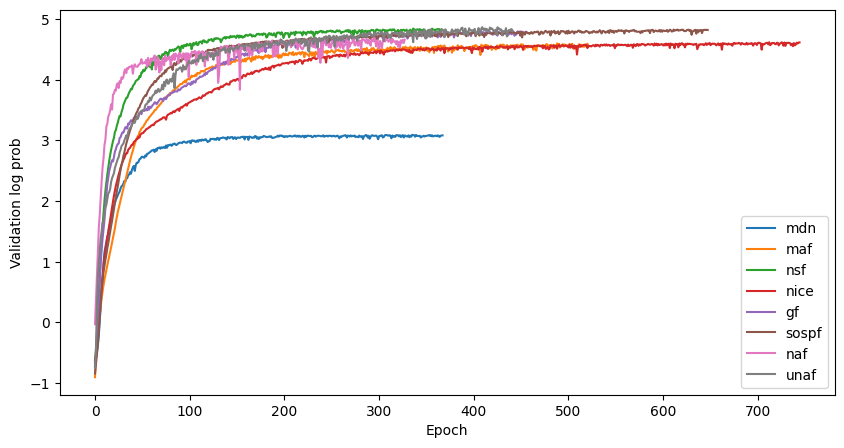

In [5]:
# plot losses
f, ax = plt.subplots(figsize=(10, 5))
for m, s in summaries.items():
    ax.plot(s[0]['validation_log_probs'], label=m)
ax.set(xlabel='Epoch', ylabel='Validation log prob')
ax.legend();

In [6]:
xv, tv = val_loader.get_all_data(), val_loader.get_all_parameters()

metrics = {}

We can then get a sense of the shape of each posterior for the same input data.

In [8]:
from ili.validation.metrics import PlotSinglePosterior

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1619it [00:00, 426062.13it/s]           
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1662it [00:00, 324229.45it/s]           
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1735it [00:00, 76259.27it/s]            
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1671it [00:00, 513682.35it/s]           
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1642it [00:00, 26592.87it/s]            
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1866it [00:00, 6734.54it/s]                         
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1398it [00:00, 2823.53it/s]                         
INFO:root:Sampling models with tensor(

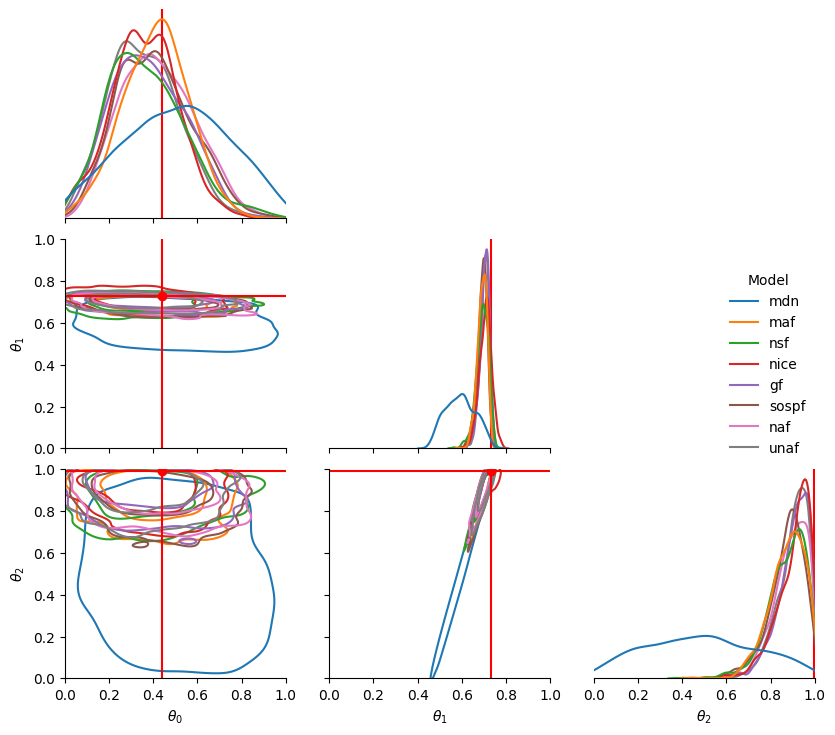

In [10]:
# specify an observation
xobs, tobs = xv[0], tv[0]

metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = None
for m, p in posteriors.items():
    fig = metric(
        posterior=p,
        x_obs = xobs, theta_fid=tobs,
        name=m,
        lower=np.zeros(3), upper=np.ones(3),
        grid = fig
    )

Our predictions are self-consistent, with some models producing more peaked (lower variance) posteriors than others. Notably, the MDN model struggles to capture $\theta_2$, due to its strong degeneracy with $\theta_1$. Now, this result is for just one example. Let's evaluate the models based on the average log posterior probability across the whole validation set.
$$\bar{\ell}_{\rm val} := \frac{1}{N_{\rm val}} \sum_{i=1}^{N_{\rm val}} \log \hat{\mathcal{P}}(\theta_i | x_i)$$
This is a measure of the precision and concentration of model posteriors.

In [11]:
val_logprobs = []
print('Validation log probs')
for m in models:
    _l = posteriors[m].log_prob(tv, xv).numpy().mean()
    val_logprobs.append(_l)
    print(f'{m}:\t{_l:.4f}')
metrics['val_logprobs'] = val_logprobs

Validation log probs
mdn:	3.0575
maf:	4.6253
nsf:	4.7478
nice:	4.6503
gf:	4.7281
sospf:	4.7847
naf:	4.6699
unaf:	4.8098


We see that some models (`mdn` in this case) have lower precision than others. However, this metric does not measure posterior coverage (i.e. accuracy of error bars). For this, we can consider measuring the average deviation of the [TARP](https://arxiv.org/abs/2302.03026) posterior coverage curves.

mdn


100%|██████████| 100/100 [00:00<00:00, 159.82it/s]


maf


100%|██████████| 100/100 [00:00<00:00, 166.40it/s]


nsf


100%|██████████| 100/100 [00:00<00:00, 167.68it/s]


nice


100%|██████████| 100/100 [00:00<00:00, 162.72it/s]


gf


100%|██████████| 100/100 [00:00<00:00, 165.38it/s]


sospf


100%|██████████| 100/100 [00:00<00:00, 170.09it/s]


naf


100%|██████████| 100/100 [00:00<00:00, 176.90it/s]


unaf


100%|██████████| 100/100 [00:00<00:00, 157.68it/s]


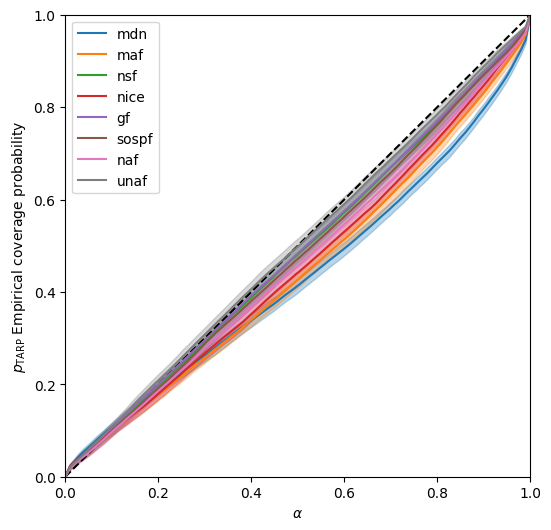

In [12]:
sampler = PosteriorSamples(num_samples=100, sample_method='direct')

f, ax = plt.subplots(figsize=(6, 6))
x_ = np.linspace(0, 1, 100)
ax.plot(x_, x_, 'k--')
ecps = []
for i, m in enumerate(models):
    print(m)
    # sample posteriors for entire validation set
    samps = sampler(posteriors[m], xv, tv)

    # measure tarp
    ecp, alpha = tarp.get_tarp_coverage(
        samps, tv,
        norm=True, bootstrap=True,
        num_bootstrap=100
    )
    ecp_mean = np.mean(ecp, axis=0)
    ecp_std = np.std(ecp, axis=0)

    # plot
    ax.plot(alpha, ecp_mean, label=m, c=f'C{i}')
    ax.fill_between(alpha, ecp_mean - ecp_std, ecp_mean + ecp_std, alpha=0.3, color=f'C{i}')
    ecps.append(ecp)
ax.set(xlabel=r'$\alpha$', ylabel=r'$p_{\rm TARP}$ Empirical coverage probability')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

metrics['tarp'] = ecps

All models exhibit a slight negative bias in their predictions, with some slightly stronger than others. This bias can be quantified in terms of the average deviation of the TARP curves at $\alpha=0.5$, i.e. $p_{\alpha=0.5}$.

We can then plot these two metrics jointly, $\bar{\ell}_{\rm val}$ and $p_{\alpha=0.5}$, to find the best model.

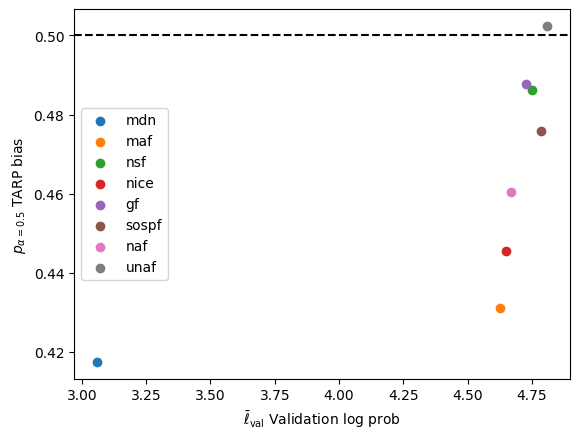

In [14]:
x_ = metrics['val_logprobs']
y_ = [np.mean(e[:,e.shape[1]//2]) for e in ecps]
f, ax = plt.subplots()
ax.axhline(0.5, color='k', linestyle='--')
for i, m in enumerate(models):
    ax.scatter(x_[i], y_[i], label=m)
ax.set(xlabel=r'$\bar{\ell}_{\rm val}$ Validation log prob', ylabel=r'$p_{\alpha=0.5}$ TARP bias')
ax.legend();

The optimal performance of these metrics is for high $\bar{\ell}_{\rm val}$ and $p_{\alpha=0.5}\rightarrow 0.5$. The closest model to this is the `unaf` model, which we would select as the best model for this toy example.

Note, despite some models having high $\bar{\ell}_{\rm val}$, they may be more biased on average.